In [1]:
%%capture
import os
from IPython.display import Javascript

os.environ['R_HOME'] = 'C:\Program Files\R\R-4.4.2'

In [2]:
# !python -m ipykernel install --user --name=ericapp --display-name "Python3(ericapp)"

In [3]:
%load_ext rpy2.ipython
%run -i ./MDT_Functions_copy.py

C:\Users\alifr\anaconda3\envs\ericapp\Lib\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [4]:
0.01### INPUT DATA
inputSpatial()

# SIMULATE RESPONSE
simulateReponse()

# ## simulate resposne
# Javascript("Jupyter.notebook.execute_cells([2])")

D:\ABMI_Official\EricCodePractice\EWNeilsen_OccupancySpatialPowerApp
The study area has (417996.4415538451, 795945.195356781, 1126884.4543278955, 1581144.825542611). 
It has 76 rows and 91 columns.

------------------
Finished inputing Use vars: ['elevation', 'water_proximity']



C:\Users\alifr\anaconda3\envs\ericapp\Lib\site-packages\osgeo\gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [5]:
# print(saAreaKM)

In [6]:
## SIMULATE OCCUANPCY DATA
simulateOccupancyData()

In [7]:
%R -i cwd
%R -i trueOcc
%R -i popPX
%R -i N
%R -i meanDetection

In [8]:
%%R

library(unmarked)
options(warn=2)

getParams = function(modObject){
    
    outParams = list()
    psiTab = predict(modObject, type="state",newdata=data.frame(1))
    outParams$psi = psiTab$Predicted
    outParams$psiSE = psiTab$SE
    outParams$psiBias = outParams$psi - trueOcc
    
    pTab = predict(modObject, type="det",newdata=data.frame(1))
    outParams$p = pTab$Predicted
    outParams$pSE = pTab$SE
    outParams$pBias = outParams$p - meanDetection
    
    return(outParams)
    }


OccOutTab = data.frame(CamN = NA, IntervalsN = NA, Response = NA, Estimate = NA,
                       SE = NA, Bias = NA, inSig = NA)


dhScenDirs = list.dirs(paste0(cwd,'/Data/DetectionHistories'),recursive = FALSE)  
# print(dhScenDirs)
scenCount = 0
FailCount = 0 

for (dir in dhScenDirs){    

    scenI = unlist(strsplit(dir,"/"))
    scen = scenI[length(scenI)]
    scen = unlist(strsplit(scen,"_"))
    CameraNumber = scen[1]
    VisitsNumber = scen[2]

    dhScens = list.files(dir,pattern="\\.csv$")
    
    for (scen in dhScens){        
        dh = read.csv(paste0(dir,"/",scen),header=T)

        ## fit model to scenario data
        umf <- unmarkedFrameOccu(y=as.matrix(dh)) # organize data
        fm <- try(occu(~1 ~1, umf)) # fit a model
        modOut = try(coef(fm)) 
#         print('')
#         print('')
#         print(class(fm))
        
        if(class(modOut) != "try-error" ){    

#             ## model outputs
#             psiTab = predict(fm, type="state",newdata=data.frame(1))
#             psi = psiTab$Predicted
#             psiSE = psiTab$SE
#             psiBias = psi - trueOcc
#             pTab = predict(fm, type="det",newdata=data.frame(1))
#             p = pTab$Predicted
#             pSE = pTab$SE
#             pBias = p - meanDetection
            
            OP = try(getParams(fm))
            if(class(OP)!= "try-error"){

                ## occupancy info
                scenCount = scenCount + 1
                OccOutTab[scenCount,"CamN"] = CameraNumber
                OccOutTab[scenCount,"IntervalsN"] = VisitsNumber
                OccOutTab[scenCount,"Response"] = "psi"
                OccOutTab[scenCount,"Estimate"] = OP$psi
                OccOutTab[scenCount,"SE"] = OP$psiSE
                OccOutTab[scenCount,"Bias"] = OP$psiBias
                OccOutTab[scenCount,"inSig"] = dplyr::between(0,OP$psi-(OP$psiSE*2.58),OP$psi+(OP$psiSE*2.58))

                ## detection info
                scenCount = scenCount + 1
                OccOutTab[scenCount,"CamN"] = CameraNumber
                OccOutTab[scenCount,"IntervalsN"] = VisitsNumber
                OccOutTab[scenCount,"Response"] = "p"
                OccOutTab[scenCount,"Estimate"] = OP$p
                OccOutTab[scenCount,"SE"] = OP$pSE
                OccOutTab[scenCount,"Bias"] = OP$pBias
                OccOutTab[scenCount,"inSig"] = dplyr::between(0,OP$p-(OP$pSE*2.58),OP$p+(OP$pSE*2.58))
            }
            else{
                FailCount = FailCount + 1 
                print("Model failed")
            }
        }
        else{
            FailCount = FailCount + 1 
            print("Model failed")
        }
    }
}



# print("Fit occupancy models to all detection histories.")
# print(paste0(FailCount," models failed."))

In [9]:
%%R
options(warn=1)
# print(OccOutTab)
require(tidyverse)

# print(OccOutTab %>% filter(Estimate>0.9999))

SumTab = OccOutTab %>%
    filter(!inSig)%>%
    group_by(CamN, IntervalsN, Response) %>%
    summarise(
        N = length(Estimate),
        
        meanEstimate = mean(Estimate),
        sdEstimate = sd(Estimate),
        seEstimate   = sdEstimate / sqrt(N),
        UpperCI_Est = quantile(Estimate,probs = 0.9),
        LowerCI_Est = quantile(Estimate,probs = 0.1),
        
        meanSE = mean(SE),
        sdSE = sd(SE),
        seSE   = sdSE / sqrt(N),
        UpperCI_SE = quantile(SE,probs = 0.9),
        LowerCI_SE = quantile(SE,probs = 0.1),
        
        meanBias = mean(Bias),
        sdBias = sd(Bias),
        seBias   = sdBias / sqrt(N),
        UpperCI_Bias = quantile(Bias,probs = 0.9),
        LowerCI_Bias = quantile(Bias,probs = 0.1)) %>%

    mutate(CamN = as.factor(CamN),
           Durations = as.numeric(IntervalsN))

R[write to console]: Loading required package: tidyverse



-- Attaching core tidyverse packages ---------------------------------------------------------------- tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.1     v tibble    3.2.1
v lubridate 1.9.4     v tidyr     1.3.1
v purrr     1.0.2     
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
`summarise()` has grouped output by 'CamN', 'IntervalsN'. You can override using the `.groups` argument.


R[write to console]: Warning:
R[write to console]:  Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated.



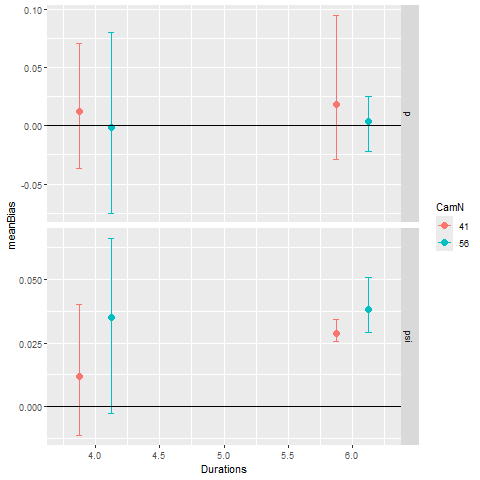

In [10]:
%%R

pd <- position_dodge(0.5)
SumTab %>%
    filter(!is.na(sdEstimate),meanEstimate < 0.99, meanEstimate > 0.001)%>%
    ggplot(
        aes(x=Durations, y=meanBias,ymin=LowerCI_Bias, ymax=UpperCI_Bias, colour=CamN)) + 
        #aes(x=Durations, y=meanEstimate,ymin=UpperCI_Est, ymax=LowerCI_Est, colour=CamN)) +
        geom_errorbar(width=0.1,position = pd)+
        geom_point(size = 3, position = pd) +        
        facet_grid(Response~.,scales="free") +
        geom_abline(size=0.5,intercept = 0, slope=0) 

In [34]:
%%R -o plot_path

library(ggplot2)
library(dplyr)

pd <- position_dodge(0.5)

# Generate the plot
plot <- SumTab %>%
    filter(!is.na(sdEstimate), meanEstimate < 0.99, meanEstimate > 0.001) %>%
    ggplot(
        aes(x=Durations, y=meanBias, ymin=LowerCI_Bias, ymax=UpperCI_Bias, colour=CamN)
    ) + 
        geom_errorbar(width=0.1, position=pd) +
        geom_point(size=3, position=pd) +        
        facet_grid(Response~., scales="free") +
        geom_abline(size=0.5, intercept=0, slope=0)

# Save the plot as an image file
plot_path <- "my_plot.png"  # Saves it in the current working directory
ggsave(plot_path, plot, width=6, height=4, dpi=100)


In [35]:
print(plot_path)

[1] "my_plot.png"



In [36]:
import ipywidgets as widgets
from IPython.display import display, Image

# Convert R's StrVector to a regular Python string
plot_path = str(plot_path[0])  # Extract the string value

# Ensure the path is correct
print("Plot saved at:", plot_path)  # Debugging step

# Open and display the saved plot using ipywidgets
with open(plot_path, "rb") as f:
    plot_widget = widgets.Image(value=f.read(), format='png')

# Wrap it inside a VBox container
vbox_container = widgets.VBox([plot_widget])

# Display the VBox containing the plot
display(vbox_container)


Plot saved at: my_plot.png


In [38]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
import rpy2.robjects.pandas2ri

# Activate automatic conversion between pandas and R dataframes
rpy2.robjects.pandas2ri.activate()

# Define UI widgets for input adjustments
mean_estimate_slider = widgets.FloatRangeSlider(
    value=[0.001, 0.99], min=0.0, max=1.0, step=0.01,
    description="Mean Estimate",
    continuous_update=False
)

# Output widget for displaying the plot
plot_output = widgets.Output()

# Function to update the plot dynamically
def update_plot(change):
    with plot_output:
        clear_output(wait=True)  # Clear previous output before updating

        # Convert Python slider values to R
        min_estimate, max_estimate = mean_estimate_slider.value
        ro.r.assign("min_estimate", min_estimate)
        ro.r.assign("max_estimate", max_estimate)

        # Execute R code to generate the plot
        ro.r('''
            library(ggplot2)
            library(dplyr)
            pd <- position_dodge(0.5)

            # Filter data dynamically
            plot <- SumTab %>%
                filter(!is.na(sdEstimate), meanEstimate < max_estimate, meanEstimate > min_estimate) %>%
                ggplot(
                    aes(x=Durations, y=meanBias, ymin=LowerCI_Bias, ymax=UpperCI_Bias, colour=CamN)
                ) + 
                    geom_errorbar(width=0.1, position=pd) +
                    geom_point(size=3, position=pd) +        
                    facet_grid(Response~., scales="free") +
                    geom_abline(size=0.5, intercept=0, slope=0)

            # Save plot to a temporary file
            plot_path <- tempfile(fileext=".png")
            ggsave(plot_path, plot, width=6, height=4, dpi=100)
        ''')

        # Retrieve the saved plot path
        plot_path = str(ro.r('plot_path')[0])  # Convert R StrVector to Python string

        # Display updated plot
        with open(plot_path, "rb") as f:
            img_widget = widgets.Image(value=f.read(), format='png')

        display(img_widget)

# Attach the update function to the slider
mean_estimate_slider.observe(update_plot, names='value')

# Display UI and initialize the first plot
display(mean_estimate_slider, plot_output)

# Generate the initial plot
update_plot(None)


FloatRangeSlider(value=(0.001, 0.99), continuous_update=False, description='Mean Estimate', max=1.0, step=0.01…

Output()